# Parse DNNMark debug logs for convolution algos and times

In [1]:
%matplotlib inline
import re
import sys
import os
import io
from cycler import cycler
import matplotlib
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import LinearLocator
import pandas as pd
import lib

In [2]:
print "Numpy:", np.__version__
print "Pandas:", pd.__version__
print "Matplotlib:", matplotlib.__version__
print "Seaborn:", sns.__version__

Numpy: 1.16.4
Pandas: 0.23.4
Matplotlib: 2.2.3
Seaborn: 0.9.0


### Functions

In [3]:
def drawGrid(ax, xstep=50, ystep=None):
    ax.grid(ls=":", alpha=.6)
#     ax.set_ylabel("time (s)")
    ax.set_xlim(0, None)
    ax.set_ylim(0, None)
    minorLocatorX = MultipleLocator(xstep / 5)
    majorLocatorX = MultipleLocator(xstep)
    ax.xaxis.set_major_locator(majorLocatorX)
    ax.xaxis.set_minor_locator(minorLocatorX)
    if ystep is not None:
        minorLocatorY = MultipleLocator(ystep / 5.)
        majorLocatorY = MultipleLocator(ystep)
        ax.yaxis.set_minor_locator(minorLocatorY)
        ax.yaxis.set_major_locator(majorLocatorY)
    ax.grid(which='minor', linestyle=':', linewidth=.5, alpha=.5)
    ax.grid(which="major", ls=":", alpha=0.25, color="black")


def readLogFiles(logdir, pars):
    dflog = lib.lib.readLogs(logdir, pars, debug=False)
    if dflog is None or dflog.shape[0] < 1:
        print logdir, "No logs!"
        return None
    dflog[["batch", "run"]] = dflog[["batch", "run"]].astype(np.int)
    dflog[["time"]] = dflog[["time"]].astype(np.float)
    # Convert ms to s
    dflog["time"] = dflog["time"] / 1000.
    dflog.sort_values(by=["batch"], inplace=True)
    dflog.reset_index(drop=True, inplace=True)
    return dflog

## Read logs

In [28]:
output_patterns = [
    re.compile(r"Total running time\(ms\): ([0-9\.\e\+]+)"),
    re.compile(r"NVDRV:([0-9\.\-]+),CUDA:([0-9\.\-]+),cuDNN:([0-9\-\.]+)"),
    re.compile(r"GPU[0-9]+: ([^,]+), ([0-9]+) MiB, ([0-9]+) MiB"),
    re.compile(r"CPU\(s\):\s+(\d+)"),
    re.compile(r"Model name:\s+(.+)"),
    re.compile(r"CPU MHz:\s+([0-9\.]+)"),
    re.compile(r"CPU max MHz:\s+([0-9\.]+)"),
    re.compile(r"FWD conv. algo: (\d)"),
    re.compile(r"BWD conv. Filter algo: (\d)"),
    re.compile(r"BWD conv. Data algo: (\d)"),
    re.compile(r"ConvFwd_1: ([0-9\.\e\+]+)ms"),
    re.compile(r"ConvBwdFilter_1: ([0-9\.\e\+]+)ms"),
    re.compile(r"ConvBwdData_1: ([0-9\.\e\+]+)ms")
]
filename_pattern = re.compile(
    r"^dnnmark_([a-zA-Z0-9@\.]+)_convolution_block_shape([0-9\-]+)_bs([0-9]+)_algos([a-z0-9]+)-([a-z0-9]+)-([0-9a-z]*)_([0-9]+)\.log$")
columns = ["machine", "shape", "batch", "algofwd", "algo", "algod", "run"]
pars = {
    "output_patterns":
    output_patterns,
    "parameters": [
        "time", ["NVdrv", "CUDA", "cuDNN"], ["GPU model", "GPU memory.total", "GPU memory.free"], "CPUs", "CPU model",
        "CPU MHz", "CPU MHz max", "fwdalgo", "bwdalgo", "bwdalgodata", "ConvFwd_time", "ConvBwdFilter_time",
        "ConvBwdData_time"
    ],
    "filename_pattern":
    filename_pattern,
    "columns":
    columns
}

logdir = "logs/mouse/dnnmark_convolution_block_microseries_20190907"
print "Reading from", logdir
df_logs = readLogFiles(logdir, pars)

for machine, mgroup in df_logs.groupby(["machine"]):
    print "{}\t:\t{}".format(machine, mgroup.shape[0])

# Check errors
error_logs = df_logs[df_logs.isna().any(axis=1)]
if error_logs.shape[0] > 0:
    print error_logs.shape[0], "errors"
    print error_logs.loc[:, error_logs.isna().any(axis=0)]

Reading from logs/mouse/dnnmark_convolution_block_microseries_20190907
mouse	:	6740


In [29]:
df_logs.head(3)

,machine,shape,batch,algofwd,algo,algod,run,time,NVdrv,CUDA,...,CPUs,CPU model,CPU MHz,CPU MHz max,fwdalgo,bwdalgo,bwdalgodata,ConvFwd_time,ConvBwdFilter_time,ConvBwdData_time
0,mouse,8-256-256,7,6,0,0,9,0.001881,410.78,10.0,...,6,Intel(R) Core(TM) i5-8400 CPU @ 2.80GHz,3777.723,4000.0000,6,0,0,0.425049,0.788086,0.498047
1,mouse,16-64-128,7,0,5,5,1,0.001023,410.78,10.0,...,6,Intel(R) Core(TM) i5-8400 CPU @ 2.80GHz,3809.065,4000.0000,0,5,0,0.311035,0.190918,0.328125
2,mouse,16-64-128,7,0,5,5,0,0.001058,410.78,10.0,...,6,Intel(R) Core(TM) i5-8400 CPU @ 2.80GHz,3704.486,4000.0000,0,5,0,0.315918,0.207031,0.327881


### Convert column types

In [30]:
float_columns = ["time","CPU MHz", "CPU MHz max", "ConvFwd_time", "ConvBwdFilter_time" , "ConvBwdData_time"]
df_logs[float_columns] = df_logs[float_columns].astype(float)
int_columns = ["batch", "fwdalgo", "bwdalgo", "bwdalgodata"]
df_logs[int_columns] = df_logs[int_columns].astype(int)

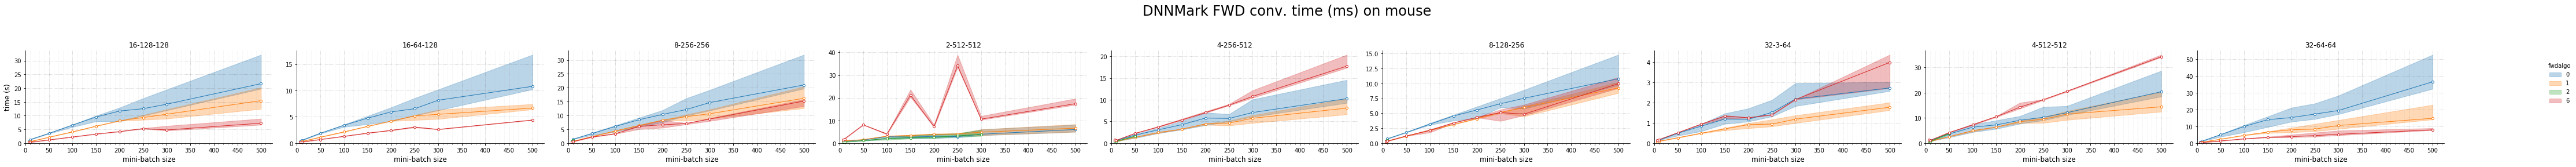

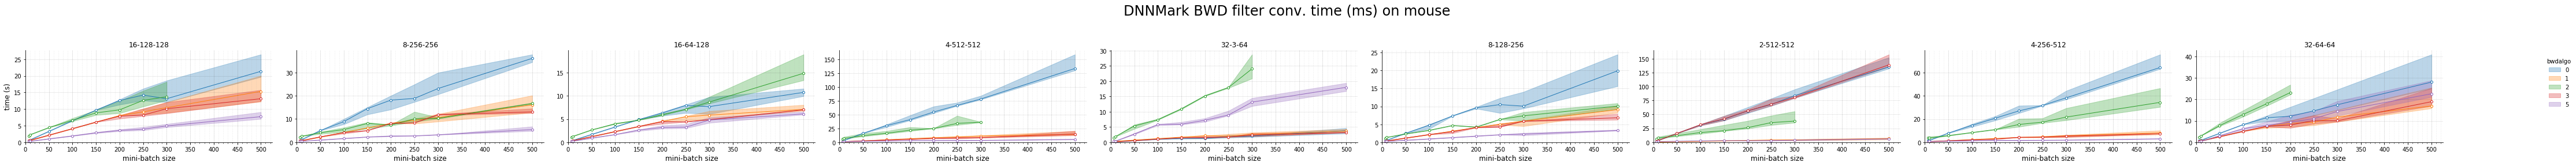

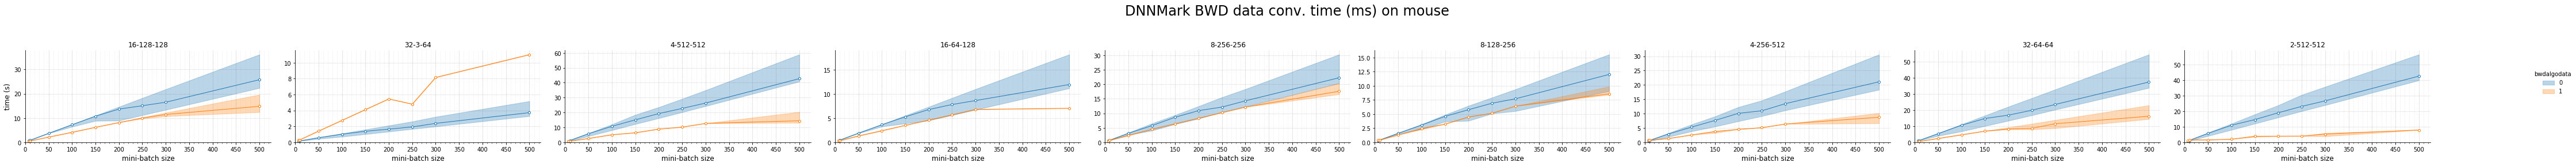

In [36]:
for machine in df_logs["machine"].unique():
    mlogs = df_logs[df_logs["machine"] == machine]
    for algos in [["fwdalgo", "ConvFwd_time", "FWD conv."],
                  ["bwdalgo", "ConvBwdFilter_time", "BWD filter conv."],
                  ["bwdalgodata", "ConvBwdData_time", "BWD data conv."]]:
        group_columns = ["machine", "shape", "batch", algos[0]]
        keep_columns = group_columns + [algos[1]]

        algo_logs = mlogs[keep_columns].groupby(
            by=group_columns, as_index=False).agg(["mean", "max", "min"])
        algo_logs.reset_index(inplace=True)
        algo_logs.columns = [
            col[0] if col[1] == "" else col[1]
            for col in algo_logs.columns.values
        ]
        # Plot time per shape

        fg = sns.FacetGrid(
            algo_logs.sort_values(by=["batch"]),
            col="shape",
            hue=algos[0],
            height=4,
            aspect=1.7,
            margin_titles=True,
            sharey=False)
        # Fill between min and max
        g = fg.map(plt.fill_between, "batch", "max", "min", alpha=0.3)
        g = fg.map(
            plt.plot,
            "batch",
            "mean",
            lw=1,
            alpha=1,
            ms=4,
            marker="o",
            fillstyle="full",
            markerfacecolor="#ffffff").add_legend()

        plt.subplots_adjust(top=0.7)
        g.fig.suptitle(
            "DNNMark {} time (ms) on {}".format(algos[2], machine),
            fontsize=24)

        for ax_arr in np.nditer(fg.axes, flags=["refs_ok"]):
            ax = ax_arr.item()
            drawGrid(ax, xstep=50)

        [plt.setp(axg.texts, text="") for axg in g.axes.flat]
        g.set_titles(
            row_template='{row_name}', col_template='{col_name}', size=12)
        axes = g.axes
        for i, row in enumerate(axes):
            #     print row.shape
            for j, column in enumerate(row):
                if j == 0:
                    ax = axes[i, j]
                    ax.set_ylabel("time (s)", fontsize=12)
                if i == axes.shape[0] - 1:
                    ax = axes[i, j]
                    ax.set_xlabel("mini-batch size", fontsize=12)
        plt.show()